In [1]:
import sys
import os
sys.path.append(os.pardir)
import datetime as dt

from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams["font.family"] = "serif"
def figsize(scale, nplots=1):
    fig_width_pt = 390.0                               
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale 
    fig_height = fig_width*golden_mean*nplots
    fig_size = [fig_width, fig_height]
    return fig_size
import matplotlib.dates as mdates

from hts.utils import merge_data, load_raw_data, parse
from hts.preprocess import clean_soil, clean_air, parse_json_data, series_to_supervised, process_data_mlp, process_data_rnn

def MAE(true, predict):
    return np.mean(np.abs(true - predict))

In [2]:
air_path = '../hts/data/Senzor_zraka.csv'
pressure_path = '../hts/data/DHMZ.csv'
soil_path = '../hts/data/Senzor_zemlje_2.csv'
test_soil_path = '../hts/data/sensor_earth1.csv'

In [3]:
soil_raw, pressure_raw, air_raw = load_raw_data(soil_path, pressure_path, air_path)
soil = clean_soil(soil_raw, absolute=False)
pressure = clean_air(pressure_raw)
air = clean_air(air_raw)

test_soil_raw, pressure_raw, air_raw = load_raw_data(test_soil_path, pressure_path, air_path)
test_soil = parse_json_data(test_soil_raw)
test_soil = clean_soil(test_soil, absolute=False)

data = merge_data(pressure, air, soil, drop_duplicate_time=True)
test_data = merge_data(pressure, air, test_soil, drop_duplicate_time=True)

In [4]:
data_reframed = series_to_supervised(data.values, n_in=1)
data_reframed.drop('var6(t-1)', axis=1, inplace=True)

In [5]:
x_train, y_train, x_valid, y_valid, x_test, y_test, scaler = \
            process_data_mlp(data, 0.6)

In [6]:
model_1 = load_model('../saved_models/NN_128_64.h5')
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


In [7]:
y_train_pred = model_1.predict(x_train)
y_train_pred = np.concatenate((x_train, y_train_pred.reshape(-1,1)), axis=1)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train = np.concatenate((x_train, y_train.reshape(-1,1)), axis=1)
y_train = scaler.inverse_transform(y_train)

y_valid_pred = model_1.predict(x_valid)
y_valid_pred = np.concatenate((x_valid, y_valid_pred.reshape(-1,1)), axis=1)
y_valid_pred = scaler.inverse_transform(y_valid_pred)
y_valid = np.concatenate((x_valid, y_valid.reshape(-1,1)), axis=1)
y_valid = scaler.inverse_transform(y_valid)

y_test_pred = model_1.predict(x_test)
y_test_pred = np.concatenate((x_test, y_test_pred.reshape(-1,1)), axis=1)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = np.concatenate((x_test, y_test.reshape(-1,1)), axis=1)
y_test = scaler.inverse_transform(y_test)

In [8]:
mae_nn = MAE(y_test[:, -1], y_test_pred[:, -1])
mae_nn

2.06170190786211

In [9]:
x_len = np.arange(y_train[:, -1].size + y_valid[:, -1].size + y_test[:, -1].size)

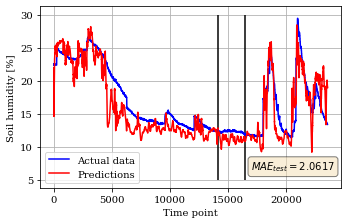

In [10]:
fig = plt.figure(figsize=figsize(1, 1))
plt.plot(x_len[:y_train[:, -1].size], y_train[:, -1], 'b-', label='Actual data')
plt.plot(x_len[:y_train[:, -1].size], y_train_pred[:, -1], 'r-', label='Predictions')
plt.vlines(x_len[y_train[:, -1].size], 5, 30, colors='k')
plt.plot(x_len[y_train[:, -1].size:y_train[:, -1].size + y_valid[:, -1].size], y_valid[:, -1], 'b-')
plt.plot(x_len[y_train[:, -1].size:y_train[:, -1].size + y_valid[:, -1].size], y_valid_pred[:, -1], 'r-')
plt.vlines(x_len[y_train[:, -1].size + y_valid[:, -1].size], 5, 30, colors='k')
plt.plot(x_len[y_train[:, -1].size + y_valid[:, -1].size:], y_test[:, -1], 'b-')
plt.plot(x_len[y_train[:, -1].size + y_valid[:, -1].size:], y_test_pred[:, -1], 'r-')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(17000, 8, r'$MAE_{test} = 2.0617$', verticalalignment='top', bbox=props)
plt.ylabel('Soil humidity [%]')
plt.xlabel('Time point')
plt.legend()
plt.grid()
plt.savefig('../figs/nn.pdf', pad_inches='tight')
plt.show()

In [11]:
x_train, y_train, x_valid, y_valid, x_test, y_test, \
            scaler = process_data_rnn(data, 6, 0.6)

In [12]:
model_2 = load_model('../saved_models/LSTM_step6_1_12.h5')
model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12)                864       
_________________________________________________________________
dense (Dense)                (None, 20)                260       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,145
Trainable params: 1,145
Non-trainable params: 0
_________________________________________________________________


In [13]:
y_train_pred = model_2.predict(x_train)
x_train = x_train[:, 0, :]
y_train_pred = np.concatenate((x_train, y_train_pred.reshape(-1,1)), axis=1)
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train = np.concatenate((x_train, y_train.reshape(-1,1)), axis=1)
y_train = scaler.inverse_transform(y_train)

y_valid_pred = model_2.predict(x_valid)
x_valid = x_valid[:, 0, :]
y_valid_pred = np.concatenate((x_valid, y_valid_pred.reshape(-1,1)), axis=1)
y_valid_pred = scaler.inverse_transform(y_valid_pred)
y_valid = np.concatenate((x_valid, y_valid.reshape(-1,1)), axis=1)
y_valid = scaler.inverse_transform(y_valid)

y_test_pred = model_2.predict(x_test)
x_test = x_test[:, 0, :]
y_test_pred = np.concatenate((x_test, y_test_pred.reshape(-1,1)), axis=1)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test = np.concatenate((x_test, y_test.reshape(-1,1)), axis=1)
y_test = scaler.inverse_transform(y_test)

In [14]:
mae_lstm = MAE(y_test[:, -1], y_test_pred[:, -1])
mae_lstm

1.9946141148187948

In [15]:
x_len = np.arange(y_train[:, -1].size + y_valid[:, -1].size + y_test[:, -1].size)

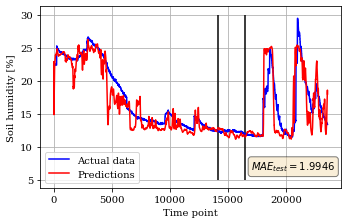

In [16]:
fig = plt.figure(figsize=figsize(1, 1))
plt.plot(x_len[:y_train[:, -1].size], y_train[:, -1], 'b-', label='Actual data')
plt.plot(x_len[:y_train[:, -1].size], y_train_pred[:, -1], 'r-', label='Predictions')
plt.vlines(x_len[y_train[:, -1].size], 5, 30, colors='k')
plt.plot(x_len[y_train[:, -1].size:y_train[:, -1].size + y_valid[:, -1].size], y_valid[:, -1], 'b-')
plt.plot(x_len[y_train[:, -1].size:y_train[:, -1].size + y_valid[:, -1].size], y_valid_pred[:, -1], 'r-')
plt.vlines(x_len[y_train[:, -1].size + y_valid[:, -1].size], 5, 30, colors='k')
plt.plot(x_len[y_train[:, -1].size + y_valid[:, -1].size:], y_test[:, -1], 'b-')
plt.plot(x_len[y_train[:, -1].size + y_valid[:, -1].size:], y_test_pred[:, -1], 'r-')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(17000, 8, r'$MAE_{test} = 1.9946$', verticalalignment='top', bbox=props)
plt.ylabel('Soil humidity [%]')
plt.xlabel('Time point')
plt.legend()
plt.grid()
plt.savefig('../figs/lstm.pdf', pad_inches='tight')
plt.show()

In [17]:
loss_nn = np.load('NN-losses', allow_pickle=True)
loss_lstm = np.load('LSTM-losses', allow_pickle=True)

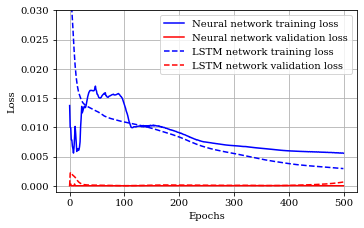

In [18]:
fig = plt.figure(figsize=figsize(1, 1))
plt.plot(loss_nn['loss'], 'b-', label='Neural network training loss')
plt.plot(loss_nn['val_loss'], 'r-', label='Neural network validation loss')
plt.plot(loss_lstm['loss'], 'b--', label='LSTM network training loss')
plt.plot(loss_lstm['val_loss'], 'r--', label='LSTM network validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(bottom=-0.001, top=0.03)
plt.legend()
plt.grid()
plt.savefig('../figs/loss.pdf', pad_inches='tight')
plt.show()